the basic idea for my strategy is to adjust my portfolio monthly or quarterly based on feature_3 and after that we can change the portofolio on a daily base based on feature_9 to improve the performance of inventory, the training period is 2010-2015 and the test period is 2017,2018

In [5]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')



In [2]:
feature_3 = pd.read_csv("feature_3.csv")
feature_9 = pd.read_csv("feature_9.csv")
stock_rtn = pd.read_csv("stock_rtn.csv")

In [8]:
def add_quarter_month(dataframe):
    def tranfer(string):
        if string in ["01","02","03"]:
            return 1
        if string in ["04","05","06"]:
            return 2
        if string in ["07","08","09"]:
            return 3
        if string in ["10","11","12"]:
            return 4
    dataframe["year"] = dataframe["data_date"].apply(lambda x: int(str(x)[:4]))
    dataframe["month"] = dataframe["data_date"].apply(lambda x:str(x)[:6])
    dataframe["quarter"] = dataframe["data_date"].apply(lambda x: tranfer(str(x)[4:6]))
    dataframe["year"] = dataframe["year"].apply(lambda x: str(x))
    dataframe["quarter"] = dataframe["quarter"].apply(lambda x: "q"+str(x))
    dataframe["quarter"]  = dataframe["year"] + dataframe["quarter"] 
    return dataframe

def Rank_qcut(vector, K):
    quantile = np.array([float(i) / K for i in range(K + 1)]) # Quantile: K+1 values
    funBounder = lambda x: (quantile >= x).argmax()
    return vector.rank(pct=True).apply(funBounder)



def cal_rtn(series):
    num = len(series)
    list_temp = []
    ret_temp = 1
    for i in range(num):
        ret_temp *= (1+series[i])
        list_temp.append(ret_temp)
    return list_temp

calaulate the monthly and quarterly return of a stock and add it to feature_3

In [4]:
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn_mon = stock_rtn.groupby(["security_id","month"])["log_ret_1"].sum()
stock_rtn_mon = pd.DataFrame(stock_rtn_mon)
stock_rtn_mon["month_ret"]= stock_rtn_mon["log_ret_1"].apply(lambda x: math.exp(x)-1)
stock_rtn_mon.to_csv("stock_rtn_month.csv")
stock_rtn_quarter = stock_rtn.groupby(["security_id","quarter"])["log_ret_1"].sum()
stock_rtn_quarter = pd.DataFrame(stock_rtn_quarter)
stock_rtn_quarter["quarter_ret"]= stock_rtn_quarter["log_ret_1"].apply(lambda x: math.exp(x)-1)
stock_rtn_quarter.to_csv("stock_rtn_quarter.csv")

In [8]:
feature_3  = add_quarter_month(feature_3)

In [9]:
quarter_list = sorted(list(set(feature_3["quarter"])))
def next_quarter(x):
    ind = quarter_list.index(x)
    try:
        return quarter_list[ind+1]
    except:
        return np.nan
month_list = sorted(list(set(feature_3["month"])))

def next_month(x):
    ind = month_list.index(x)
    try:
        return month_list[ind+1]
    except:
        return np.nan
    
feature_3["next_quarter"] = feature_3["quarter"].apply(next_quarter)
feature_3["next_month"] = feature_3["month"].apply(next_month)
feature_3 = feature_3[["data_date","security_id","d3","quarter","month","next_quarter","next_month"]].fillna(0)

add next_month return and next_quarter return 

In [10]:
stock_rtn_quarter = pd.read_csv("stock_rtn_quarter.csv")
stock_rtn_month = pd.read_csv("stock_rtn_month.csv")
stock_rtn_month["next_month"] = stock_rtn_month["month"]
stock_rtn_quarter["next_quarter"] = stock_rtn_quarter["quarter"]


In [11]:
feature_3 = pd.merge(feature_3,stock_rtn_quarter,on = ["security_id","next_quarter"],how = "left")
feature_3 =  pd.merge(feature_3,stock_rtn_month,on = ["security_id","next_month"],how = "left")

In [12]:
feature_3 = feature_3[["data_date","security_id","d3","next_quarter","next_month","month_ret","quarter_ret"]]
feature_3 = feature_3.dropna()
feature_3.index = range(len(feature_3))

# construction of the strategy

to start with we will explore the strategy without considering whether a stock is in the universe, here feature_3_monthly_quarterly.csv contains feature_3 of last month and last quarter

In [29]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_quarter"]]
feature_3["matching_quarter"] = feature_3["next_quarter"]
feature_3["matching_quarter"] = feature_3["matching_quarter"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_quarter",axis =1)

change the portfolio quarterly

In [30]:
stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_quarter"] = stock_rtn["quarter"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_quarter"],how = "left")


In [31]:
stock_rtn = stock_rtn.dropna()

In [32]:
def classificaiton_rtn_daily(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        #q1 = q1[q1.in_trading_universe == "Y"]
        if i % 66 ==0:
            #trading fee each quarter
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean() -0.0002)
        else:
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

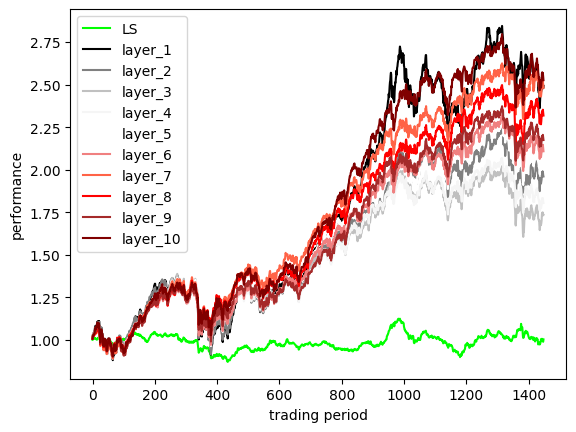

In [33]:
stock_rtn_training = stock_rtn[stock_rtn.year <= "2015"]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

In [34]:
k = pd.Series(k10)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.2324060574743414
annual return 0.17368056367279605
Sharpe ratio 0.9991087517141639


In [35]:
k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.33849579996919
annual return 0.1709441782066612
Sharpe ratio 0.8367429955000509


layer_10 has the best performance and the long-short strategy does not have a good performance

In [20]:
def layer_by_day(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        if len(df_init) == 0:
            df_init = q1
        else:
            df_init = pd.concat([df_init,q1])
    return df_init

In [ ]:
stock_rtn_with_feature_3_layer = layer_by_day(stock_rtn)
stock_rtn_with_feature_3_layer.to_csv("stock_rtn_with_feature_3_quarter.csv")

In [ ]:
stock_rtn_with_feature_3_layer

change the portfolio monthly

In [36]:
def classificaiton_rtn_daily(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        #q1 = q1[q1.in_trading_universe == "Y"]
        if i % 22 ==0:
            #trading fee each month
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean() -0.0002)
        else:
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

In [37]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_month"]]
feature_3["matching_month"] = feature_3["next_month"]
feature_3["matching_month"] = feature_3["matching_month"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_month",axis =1)

In [38]:
stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_month"] = stock_rtn["month"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_month"],how = "left")
stock_rtn = stock_rtn.dropna()

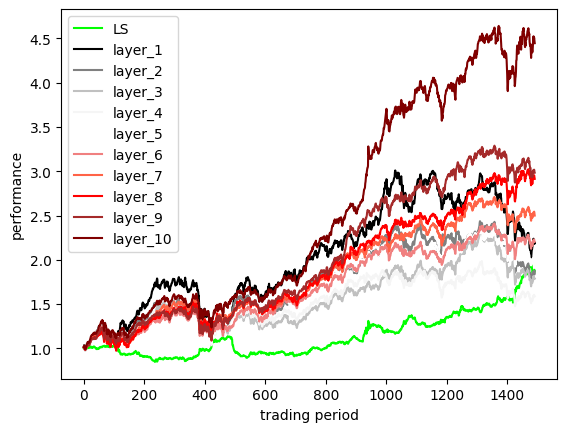

In [39]:
stock_rtn_training = stock_rtn[stock_rtn.year <= "2015"]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
df_T["LS"] = df_T[10]-df_T[1]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

In [40]:
k = pd.Series(k10)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.23583011527779651
annual return 0.2832471166268069
Sharpe ratio 1.582073737577745


conclusion:change the portfolio monthly is significantly better than change the portfolio quarterly, and long layer 10 seems the best

and we are going to add feature_3 layer label to the stock return according to changing portifolio monthly

In [41]:
def layer_by_day(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        if len(df_init) == 0:
            df_init = q1
        else:
            df_init = pd.concat([df_init,q1])
    return df_init

In [ ]:
stock_rtn_with_feature_3_layer = layer_by_day(stock_rtn)

In [26]:
stock_rtn_with_feature_3_layer.to_csv("stock_rtn_with_feature_3_month.csv")

In [27]:
stock_rtn_with_feature_3_layer

,Unnamed: 0.1,Unnamed: 0,data_date,security_id,close_price,volume,group_id,in_trading_universe,ret1d,log_ret_1,year,month,quarter,matching_month,d3,layer
88662,88662,88662,20100201,93201,33.440,90457.0,15103010,N,-0.042108,-0.000299,2010,201002,2010q1,201002,154.669847,9
88667,88667,88667,20100201,131901,21.640,7891942.0,15104050,Y,0.063914,0.011486,2010,201002,2010q1,201002,-30.124976,2
88670,88670,88670,20100201,137201,1.300,18000.0,20104010,N,-0.015151,-0.015426,2010,201002,2010q1,201002,146.038376,9
88672,88672,88672,20100201,140501,1.980,41203.0,45203015,N,-0.010000,0.020001,2010,201002,2010q1,201002,64.522799,5
88675,88675,88675,20100201,147701,25.380,36774300.0,50101020,Y,0.000788,0.012141,2010,201002,2010q1,201002,76.222480,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8618848,8617904,4306229,20171031,1115924801,34.050,338353.0,20107010,Y,0.015206,-0.009442,2017,201710,2017q4,201710,50.668755,7
8618879,8617935,4306260,20171031,1116120701,20.500,175141.0,25504060,N,0.004902,0.013566,2017,201710,2017q4,201710,-65.408053,2
8618906,8617962,4306287,20171031,1116292901,34.750,214123.0,45101010,Y,0.014303,0.013718,2017,201710,2017q4,201710,-0.871261,4
8618942,8617998,4306323,20171031,1116510501,3.625,8646.0,40203010,N,0.006944,0.020479,2017,201710,2017q4,201710,-607.543794,1


now try to add feature_9 to monthly portfolio

In [43]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_month.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 10]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [44]:
def classificaiton_rtn(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    trade_list = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        trade_list.append(list(set(q1["security_id"])))
        factor_df_layers = Rank_qcut(q1["d9"], 7)
        q1["layer"] = factor_df_layers
        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
            
        rtn_temp = pd.DataFrame(q1.groupby("layer")["fut_rtn_1d"].mean()-0.0001*turnover_temp)
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

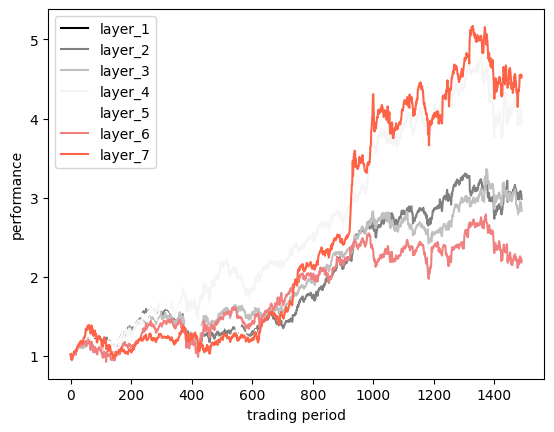

max drawdown： -0.2968367150909309
annual return 0.285396867790245
Sharpe ratio 1.1557869747896745


In [45]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year <= 2015)]
df = classificaiton_rtn(stock_rtn_layer_10)
df = df
df_T = df.T
df_T.index = range(len(df_T))
# df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
# k8 = cal_rtn(df_T[8])
# k9 = cal_rtn(df_T[9])
# k10 = cal_rtn(df_T[10])
# k11 = cal_rtn(df_T["LS"])
# plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
# plt.plot(x,k8,color = 'red',label="layer_8")
# plt.plot(x,k9,color = 'brown',label="layer_9")
# plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k7)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

now try to add feature_9 to quarterly portfolio

In [48]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_quarter.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 10]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [40]:
def classificaiton_rtn(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    trade_list = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d9"], 20) #classify as 20 layers 

        q1["layer"] = factor_df_layers
        trade_list.append(list(set(q1["security_id"])))

        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
        
        
            
        rtn_temp = pd.DataFrame(q1.groupby("layer")["fut_rtn_1d"].mean()-0.0001*turnover_temp)
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

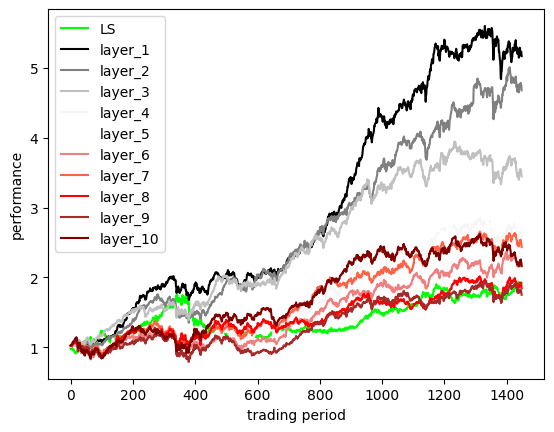

max drawdown： -0.16886938329704015
annual return 0.3291143825657479
Sharpe ratio 2.2744645278242754


In [50]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year <= 2015)]
df = classificaiton_rtn(stock_rtn_layer_10)
df = df
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

# it seems that the quarterly changed portfolio based on feature 3 with daily turnover based on feature 9 has the best performance,so we choose it as our final strategy

# out sample test:

In [31]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_quarter.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 10]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [33]:
def cal_turnover(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    trade_list = []
    turnover = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        trade_list.append(list(set(q1["security_id"])))

        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
        turnover.append(turnover_temp)
    return turnover

In [38]:
tl = cal_turnover(stock_rtn_layer_10[(stock_rtn_layer_10.year >= 2016)])
sum(tl)/len(tl)*365*2

18.73546368618219

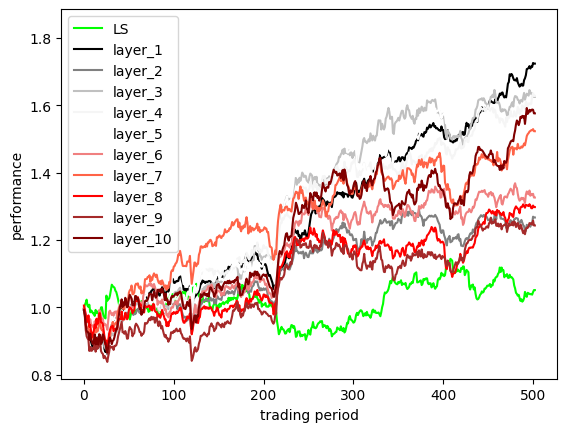

max drawdown： -0.1245660488285053
annual return 0.3198939532404299
Sharpe ratio 2.491866388113577
volatility 0.12837524305731332
wining rate 0.5685884691848907
annual turnover: 1873%


In [41]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year >= 2016)]
df = classificaiton_rtn(stock_rtn_layer_10)
df_T = df.T
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))
print("volatility",k.pct_change().std()* np.sqrt(252))
l = k.pct_change()>0
print("wining rate", len(l[l == True])/len(k))
print("annual turnover:", "1873%" )

next we will find out whether a stock is in the trading universe or not

find out the if the stock can be both in and out the trading universe

In [36]:
koi = []
for idx in list(set(stock_rtn.security_id)):
    koi.append(len(stock_rtn[(stock_rtn.security_id == idx)&(stock_rtn.in_trading_universe == "Y")])*len(stock_rtn[(stock_rtn.security_id == idx)&(stock_rtn.in_trading_universe == "N")]))

print(set(koi))

{0, 860160, 434176, 16393, 442383, 18, 639000, 835612, 40992, 36, 196650, 41004, 188478, 62, 565320, 393300, 671832, 589916, 32865, 917607, 868476, 125, 32895, 336000, 114829, 606351, 819351, 8349, 794782, 160, 24738, 278690, 237735, 147637, 925880, 184, 270522, 188, 16590, 98512, 164052, 688344, 98525, 647394, 8424, 65769, 236, 24813, 8433, 131313, 114933, 8440, 41216, 647424, 8449, 82176, 188680, 264, 284, 188700, 213280, 516385, 385314, 155936, 41248, 942375, 557355, 680238, 305, 33082, 57660, 246078, 16714, 942422, 794967, 57690, 57691, 115038, 573800, 90474, 221551, 172405, 374, 49532, 172416, 598401, 311682, 8588, 352652, 672144, 16789, 295324, 909727, 8610, 418215, 16812, 221613, 8624, 205240, 441, 139706, 762299, 33216, 721344, 295365, 262600, 164300, 713168, 8658, 377300, 8664, 270810, 188892, 336351, 66015, 156129, 479, 549351, 786927, 498, 352755, 188928, 762369, 520, 770568, 90640, 530, 500247, 98840, 385567, 721440, 57909, 572, 8766, 16960, 98890, 16974, 131670, 893527, 87

In [37]:
print(len(koi))

5245


so we find that a stock can be in and out of a trading universe 

In [53]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_quarter"]]
feature_3["matching_quarter"] = feature_3["next_quarter"]
feature_3["matching_quarter"] = feature_3["matching_quarter"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_quarter",axis =1)

In [54]:
stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_quarter"] = stock_rtn["quarter"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_quarter"],how = "left")
stock_rtn = stock_rtn.dropna()

begin with quarterly change the portfolio without considering change the daily changing of portfolio based on feature_9

In [55]:
def classificaiton_rtn_daily(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]
        if i % 66 ==0:
            #trading fee each quarter
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean() -0.0002)
        else:
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

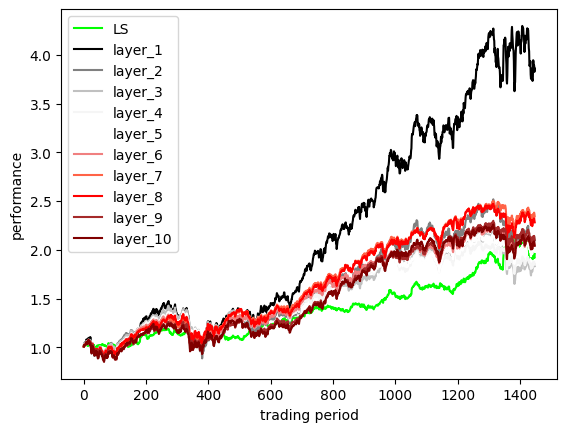

In [56]:
stock_rtn_training = stock_rtn[stock_rtn.year <= "2015"]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

In [57]:
k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.3670857494792079
annual return 0.2619202722671119
Sharpe ratio 1.043622053419279


monthly change the portfolio

In [58]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_month"]]
feature_3["matching_month"] = feature_3["next_month"]
feature_3["matching_month"] = feature_3["matching_month"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_month",axis =1)

In [59]:
stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_month"] = stock_rtn["month"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_month"],how = "left")
stock_rtn = stock_rtn.dropna()

In [60]:
def classificaiton_rtn_daily(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]
        if i % 22 ==0:
            #trading fee each month
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean() -0.0002)
        else:
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

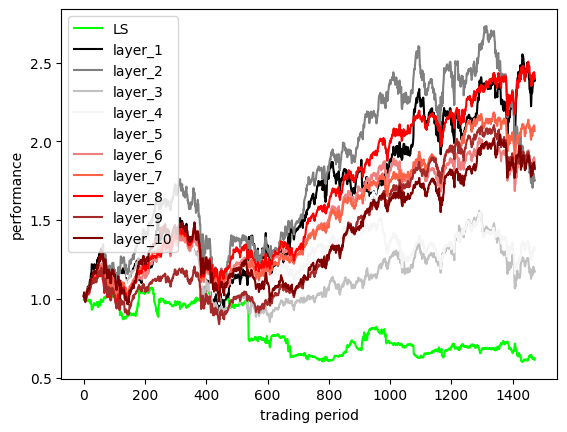

In [61]:
stock_rtn_training = stock_rtn[stock_rtn.year <= "2015" ]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
df_T["LS"] = df_T[10]-df_T[1]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

In [46]:
k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

max drawdown： -0.4152311783556123
annual return 0.1565128264039104
Sharpe ratio 0.5518690044951696


In [47]:
def layer_by_day(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        if len(df_init) == 0:
            df_init = q1
        else:
            df_init = pd.concat([df_init,q1])
    return df_init

now add feature_9

In [69]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_month.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 10]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [70]:
def classificaiton_rtn(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    trade_list = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d9"], 7)
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]
        trade_list.append(list(set(q1["security_id"])))


        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
            
        rtn_temp = pd.DataFrame(q1.groupby("layer")["fut_rtn_1d"].mean()-0.0001*turnover_temp)
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

In [72]:
df

,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,...,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d,fut_rtn_1d
layer,,,,,,,,,,,,,,,,,,,,,
1,0.018401,-0.000975,-0.037623,0.002948,-0.010087,0.008133,-0.002400,0.011130,-0.002800,0.007873,...,-0.014181,0.005922,0.011711,0.018128,0.000142,-0.002631,0.011122,-0.006564,-0.009722,-0.012877
2,0.022116,0.002368,-0.034866,0.006703,-0.011677,0.028165,0.000538,0.010385,-0.018221,0.030645,...,-0.010579,0.009816,0.013816,0.014699,0.001048,-0.001872,0.008365,-0.009917,-0.011066,-0.021949
3,0.046025,-0.030734,-0.054023,-0.010233,-0.012484,0.042398,-0.003522,0.031054,0.019313,0.029168,...,-0.024530,0.012834,0.005837,0.014212,0.000019,-0.003456,0.011059,-0.009607,-0.007643,-0.016079
4,0.017713,-0.006533,-0.026043,0.001155,-0.013784,0.016103,0.000619,0.016435,0.001113,0.004783,...,-0.021561,0.016995,0.003867,0.021651,-0.000371,-0.015659,0.013919,-0.011338,-0.008803,-0.020460
5,0.029109,-0.016671,-0.039355,-0.002381,-0.008554,0.026540,0.002059,0.027311,0.009679,0.023432,...,-0.018150,0.005805,0.013315,0.017406,0.003737,-0.002936,0.008687,-0.008002,-0.014051,-0.014758
6,0.019231,-0.004609,-0.038732,-0.011963,0.003274,0.007025,0.000504,0.026942,-0.000989,0.016289,...,-0.014415,0.008760,0.020077,0.023035,0.004316,-0.016913,0.015803,-0.011007,-0.006416,-0.005235
7,0.034998,-0.016209,-0.049320,-0.000431,-0.009720,0.025362,-0.006415,0.025160,0.010664,0.025388,...,0.011291,0.011716,-0.021239,-0.006319,-0.013946,-0.018353,0.022359,0.017201,-0.018331,-0.013661


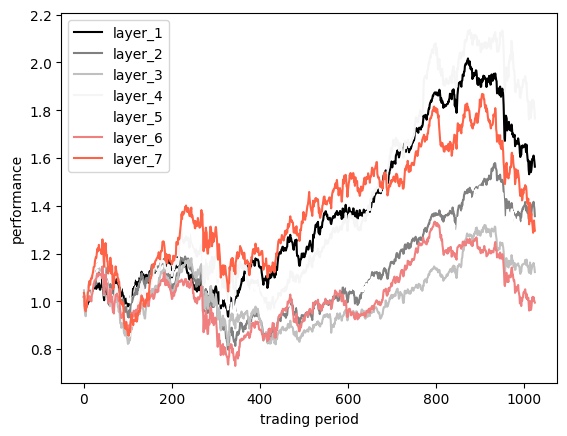

max drawdown： -0.3201860875413559
annual return 0.0567551189527018
Sharpe ratio 0.24021053440716117


In [73]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year <= 2015)]
df = classificaiton_rtn(stock_rtn_layer_10)
df = df
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
# df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
# k8 = cal_rtn(df_T[8])
# k9 = cal_rtn(df_T[9])
# k10 = cal_rtn(df_T[10])
# k11 = cal_rtn(df_T["LS"])
# plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
# plt.plot(x,k8,color = 'red',label="layer_8")
# plt.plot(x,k9,color = 'brown',label="layer_9")
# plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k7)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

now try to add feature_9 to quarterly portfolio

In [11]:
stock_rtn = pd.read_csv("stock_rtn_with_feature_3_quarter.csv")
stock_rtn_layer_10 = stock_rtn[stock_rtn.layer == 2]
feature_9 = pd.read_csv("feature_9.csv")
feature_9["fut_rtn_1d"] = np.exp(feature_9["log_ret_1"])-1
feature_9 = feature_9.drop(["log_ret_1"],axis = 1)
feature_9 = feature_9.drop(["Unnamed: 0"],axis = 1)
stock_rtn_layer_10 = pd.merge(stock_rtn_layer_10,feature_9,on = ["data_date","security_id"],how = "left")
stock_rtn_layer_10 = stock_rtn_layer_10.dropna()

In [66]:
def classificaiton_rtn(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    trade_list = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d9"], 10) #classify as 20 layers 
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]

        trade_list.append(list(set(q1["security_id"])))

        if len(trade_list) >=2:
            temp_1 = trade_list[i]
            temp_2 = trade_list[i-1]
            temp_3 = list(set(temp_1).intersection(set(temp_2)))
            turnover_temp = 2-2*(len(temp_3)/max(len(temp_1),len(temp_2)))
        else:
            turnover_temp = 0
        
        
            
        rtn_temp = pd.DataFrame(q1.groupby("layer")["fut_rtn_1d"].mean()-0.0001*turnover_temp)
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

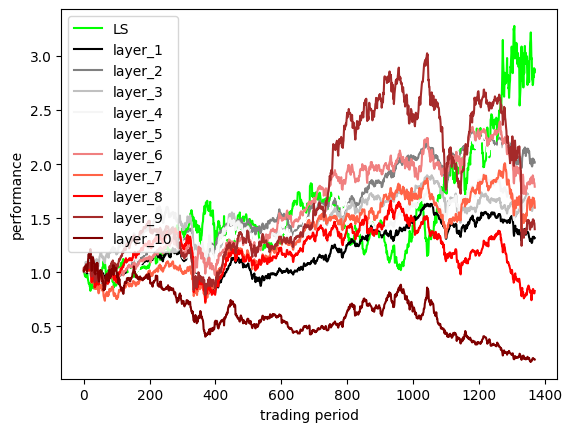

max drawdown： -0.3915657121382232
annual return 0.04797164029335477
Sharpe ratio 0.21844520802700407


In [67]:
stock_rtn_layer_10 = stock_rtn_layer_10[(stock_rtn_layer_10.year <= 2015)]
df = classificaiton_rtn(stock_rtn_layer_10)
df_T = df.T
df_T = df_T.dropna()
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))

# it seems that the quarterly changed portfolio based on feature 3 has the best performance,so we choose it as our final strategy

# out sample test:

In [12]:
feature_3 = pd.read_csv("feature_3_monthly_quarterly.csv")
feature_3 = add_quarter_month(feature_3)
feature_3 = feature_3[["security_id","d3","next_quarter"]]
feature_3["matching_quarter"] = feature_3["next_quarter"]
feature_3["matching_quarter"] = feature_3["matching_quarter"].apply(lambda x: str(x))
feature_3 = feature_3.drop("next_quarter",axis =1)

stock_rtn = pd.read_csv("stock_rtn.csv")
stock_rtn = add_quarter_month(stock_rtn)
stock_rtn["matching_quarter"] = stock_rtn["quarter"]
stock_rtn = pd.merge(stock_rtn,feature_3,on = ["security_id","matching_quarter"],how = "left")
stock_rtn = stock_rtn.dropna()

In [13]:
def classificaiton_rtn_daily(dataframe):
    date_list = sorted(list(set(dataframe.data_date)))
    df_init = []
    for i in range(len(date_list)):
        q1 = dataframe[dataframe.data_date == date_list[i]]
        factor_df_layers = Rank_qcut(q1["d3"], 10)
        q1["layer"] = factor_df_layers
        q1 = q1[q1.in_trading_universe == "Y"]
        if i % 66 ==0:
            #trading fee each quarter
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean() -0.0002)
        else:
            rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        rtn_temp = pd.DataFrame(q1.groupby("layer")["ret1d"].mean())
        if len(df_init) == 0:
            df_init = rtn_temp
        else:
            df_init = pd.concat([df_init,rtn_temp],axis = 1)
    return df_init

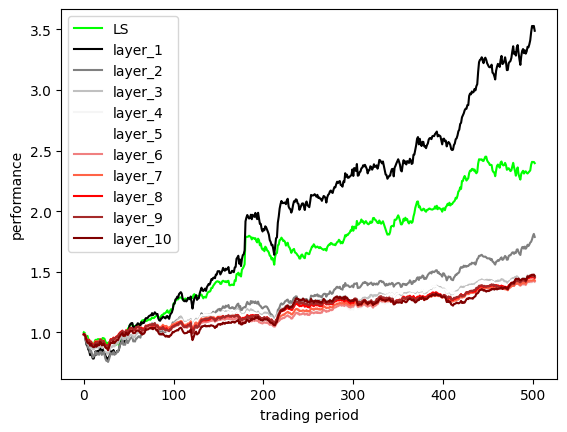

max drawdown： -0.21180219120629173
annual return 0.882953166548879
Sharpe ratio 3.2385938392199978
volatility 0.2726347329684091
wining rate 0.5725646123260437
annual turnover: 800%


In [30]:
stock_rtn_training = stock_rtn[stock_rtn.year >= "2016"]
df = classificaiton_rtn_daily(stock_rtn_training)
df_T = df.T
df_T.index = range(len(df_T))
df_T["LS"] = df_T[1]-df_T[10]
#折线图
x = df_T.index
k1 = cal_rtn(df_T[1])
k2 = cal_rtn(df_T[2])
k3 = cal_rtn(df_T[3])
k4 = cal_rtn(df_T[4])
k5 = cal_rtn(df_T[5])
k6 = cal_rtn(df_T[6])
k7 = cal_rtn(df_T[7])
k8 = cal_rtn(df_T[8])
k9 = cal_rtn(df_T[9])
k10 = cal_rtn(df_T[10])
k11 = cal_rtn(df_T["LS"])
plt.plot(x,k11,color = 'lime',label="LS")


plt.plot(x,k1,color = 'black',label="layer_1")
plt.plot(x,k2,color = 'gray',label="layer_2")
plt.plot(x,k3,color = 'silver',label="layer_3")
plt.plot(x,k4,color = 'whitesmoke',label="layer_4")
plt.plot(x,k5,color = 'white',label="layer_5")
plt.plot(x,k6,color = 'lightcoral',label="layer_6")
plt.plot(x,k7,color = 'tomato',label="layer_7")
plt.plot(x,k8,color = 'red',label="layer_8")
plt.plot(x,k9,color = 'brown',label="layer_9")
plt.plot(x,k10,color = 'maroon',label="layer_10")
plt.xlabel("trading period")#横坐标名字
plt.ylabel("performance")#纵坐标名字
plt.legend(loc = "best")#图例
plt.show()

k = pd.Series(k1)
print('max drawdown：', np.min(k / np.maximum.accumulate(k) - 1))
print('annual return', (k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)
print('Sharpe ratio',((k.iloc[-1]/k.iloc[0])**(252/len(k.index))-1)/(k.pct_change().std()* np.sqrt(252)))
print("volatility",k.pct_change().std()* np.sqrt(252))
l = k.pct_change()>0
print("wining rate", len(l[l == True])/len(k))
print("annual turnover:", "800%" )